# Retail Dataset Sequence Analysis

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from datetime import datetime
import re

# Load the dataset
# Assuming the file is in CSV format
df = pd.read_csv('../data/sample-2/processed/store_customer_sequences.csv')

# Display first few rows
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (6755, 5)


,StoreID,CustomerID,ProductID,ProductCategory,Timestamp
0,1,Cust_0000,['P105'],['Electronics'],[Timestamp('2022-01-09 20:46:00')]
1,1,Cust_0001,"['P138', 'P130', 'P127', 'P124', 'P140', 'P120...","['Home Goods', 'Electronics', 'Books', 'Electr...","[Timestamp('2022-01-03 15:31:41'), Timestamp('..."
2,1,Cust_0002,"['P143', 'P121', 'P103', 'P118', 'P149', 'P147...","['Books', 'Grocery', 'Electronics', 'Apparel',...","[Timestamp('2022-01-29 14:42:42'), Timestamp('..."
3,1,Cust_0003,"['P145', 'P104']","['Grocery', 'Apparel']","[Timestamp('2022-01-26 17:11:45'), Timestamp('..."
4,1,Cust_0004,"['P118', 'P123']","['Apparel', 'Books']","[Timestamp('2022-04-07 10:20:51'), Timestamp('..."


## Preprocesing

In [12]:
# Parse timestamps with better error handling
def parse_timestamps(ts_str):
    try:
        if pd.isna(ts_str):
            return []
        
        ts_str = str(ts_str)
        
        # Handle Timestamp('...') format
        timestamp_pattern = r"Timestamp\('([^']+)'\)"
        timestamp_strings = re.findall(timestamp_pattern, ts_str)
        
        if timestamp_strings:
            # Convert all found timestamps to datetime objects
            return [pd.Timestamp(ts) for ts in timestamp_strings]
        
        # Fallback: try the original bracket format
        matches = re.findall(r'\[(.*?)\]', ts_str)
        if matches:
            if ',' in matches[0]:
                ts_list = [t.strip().strip("'\"") for t in matches[0].split(',')]
                return [pd.to_datetime(t) for t in ts_list if t.strip()]
            else:
                return [pd.to_datetime(matches[0].strip().strip("'\""))]
        
        return []
    except Exception as e:
        print(f"Error parsing timestamp from {ts_str}: {e}")
        return []

df['Timestamp_List'] = df['Timestamp'].apply(parse_timestamps)

# Parse ProductID and ProductCategory columns
df['ProductID_List'] = df['ProductID'].apply(parse_list_column)
df['ProductCategory_List'] = df['ProductCategory'].apply(parse_list_column)


# Extract first timestamp for easier analysis
def extract_first_timestamp(timestamps):
    try:
        if isinstance(timestamps, list) and len(timestamps) > 0:
            first_ts = timestamps[0]
            # Check if it's already a pandas Timestamp object
            if isinstance(first_ts, pd.Timestamp):
                return first_ts
            else:
                return pd.to_datetime(first_ts)
        elif isinstance(timestamps, str):
            # Handle case where it's still a string
            timestamp_pattern = r"Timestamp\('([^']+)'\)"
            timestamp_strings = re.findall(timestamp_pattern, timestamps)
            if timestamp_strings:
                return pd.Timestamp(timestamp_strings[0])
        return None
    except Exception as e:
        print(f"Error extracting timestamp from {timestamps}: {e}")
        return None

# Add first timestamp column for easier processing
df['First_Timestamp'] = df['Timestamp_List'].apply(extract_first_timestamp)

# Create a new dataframe with exploded data for easier analysis
exploded_df = df.explode(['ProductID_List', 'ProductCategory_List', 'Timestamp_List'])
exploded_df = exploded_df.rename(columns={
    'ProductID_List': 'Product', 
    'ProductCategory_List': 'Category',
    'Timestamp_List': 'DateTime'
})
exploded_df = exploded_df.reset_index(drop=True)

# Ensure DateTime column is properly converted
exploded_df['DateTime'] = pd.to_datetime(exploded_df['DateTime'], errors='coerce')

exploded_df.head()

,StoreID,CustomerID,ProductID,ProductCategory,Timestamp,DateTime,Product,Category,First_Timestamp
0,1,Cust_0000,['P105'],['Electronics'],[Timestamp('2022-01-09 20:46:00')],2022-01-09 20:46:00,P105,Electronics,2022-01-09 20:46:00
1,1,Cust_0001,"['P138', 'P130', 'P127', 'P124', 'P140', 'P120...","['Home Goods', 'Electronics', 'Books', 'Electr...","[Timestamp('2022-01-03 15:31:41'), Timestamp('...",2022-01-03 15:31:41,P138,Home Goods,2022-01-03 15:31:41
2,1,Cust_0001,"['P138', 'P130', 'P127', 'P124', 'P140', 'P120...","['Home Goods', 'Electronics', 'Books', 'Electr...","[Timestamp('2022-01-03 15:31:41'), Timestamp('...",2022-01-11 14:36:27,P130,Electronics,2022-01-03 15:31:41
3,1,Cust_0001,"['P138', 'P130', 'P127', 'P124', 'P140', 'P120...","['Home Goods', 'Electronics', 'Books', 'Electr...","[Timestamp('2022-01-03 15:31:41'), Timestamp('...",2022-01-11 14:36:27,P127,Books,2022-01-03 15:31:41
4,1,Cust_0001,"['P138', 'P130', 'P127', 'P124', 'P140', 'P120...","['Home Goods', 'Electronics', 'Books', 'Electr...","[Timestamp('2022-01-03 15:31:41'), Timestamp('...",2022-01-11 14:36:27,P124,Electronics,2022-01-03 15:31:41


## EDA

Store Summary Statistics:
         Unique_Customers  Total_Transactions  Unique_Categories
StoreID                                                         
1                     786                3928                  5
2                     885                5640                  5
3                     890                5326                  5
4                     850                4661                  5
5                     842                4498                  5
6                     854                5040                  5
7                     821                4529                  5
8                     827                4312                  5


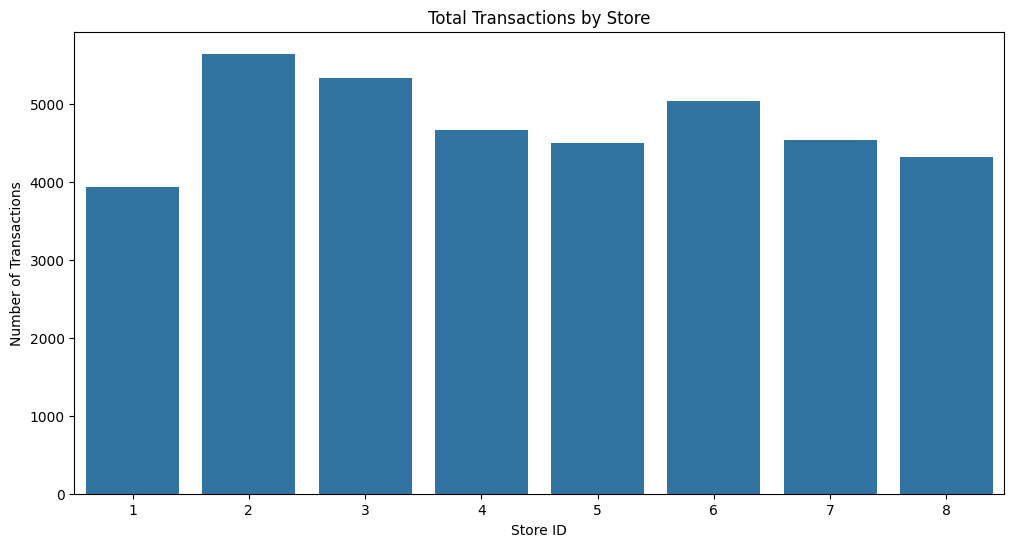

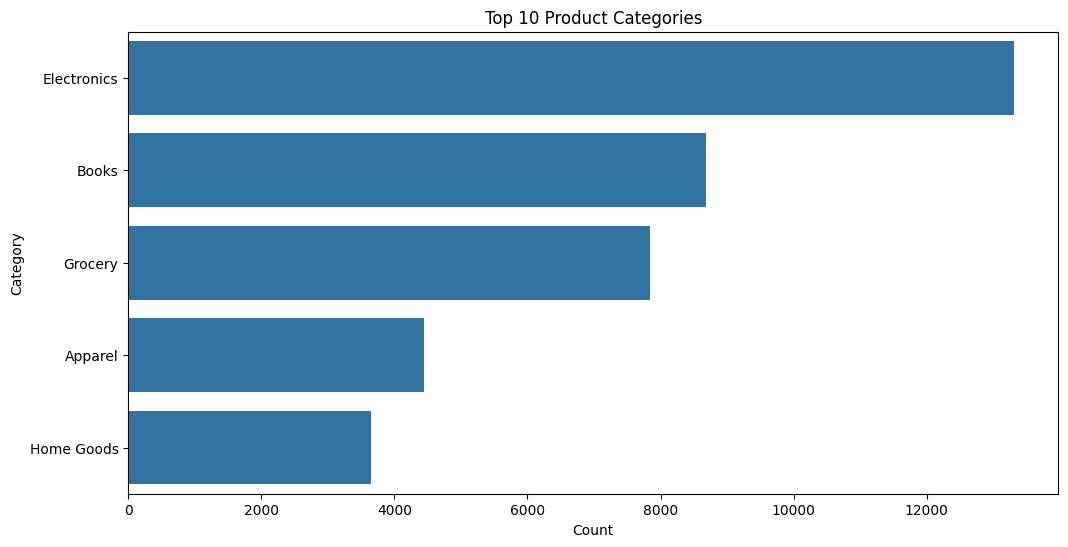

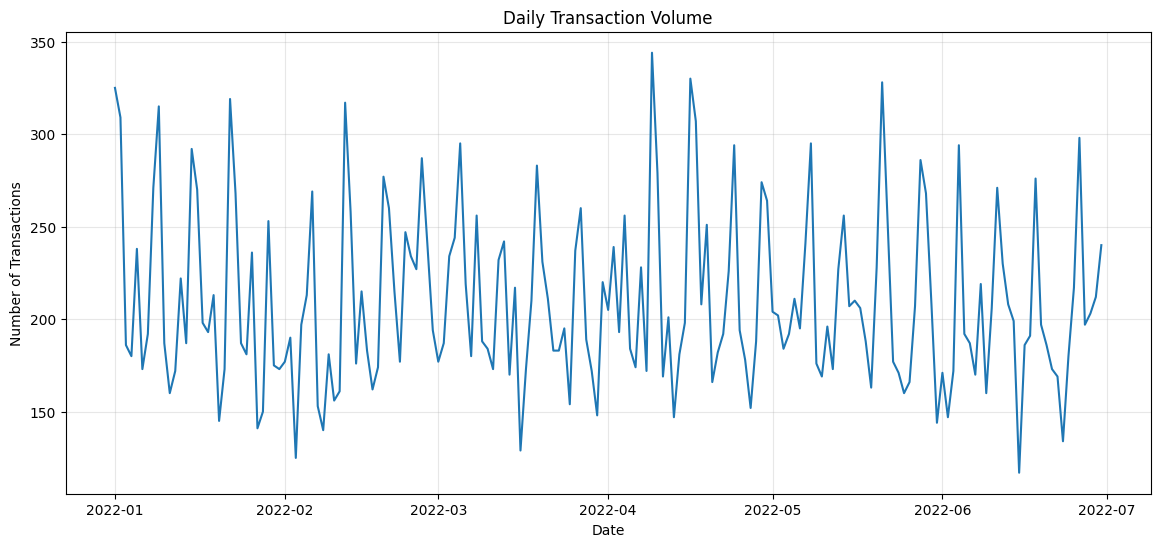

In [13]:
# Summary statistics for each store
store_summary = exploded_df.groupby('StoreID').agg({
    'CustomerID': 'nunique',
    'Product': 'count',
    'Category': lambda x: len(set(x))
}).rename(columns={
    'CustomerID': 'Unique_Customers',
    'Product': 'Total_Transactions',
    'Category': 'Unique_Categories'
})

print("Store Summary Statistics:")
print(store_summary)

# Plot transactions by store
plt.figure(figsize=(12, 6))
sns.barplot(x='StoreID', y='Total_Transactions', data=store_summary.reset_index())
plt.title('Total Transactions by Store')
plt.xlabel('Store ID')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)
plt.show()

# Top product categories
top_categories = exploded_df['Category'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(y=top_categories.index, x=top_categories.values)
plt.title('Top 10 Product Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# Transactions over time
exploded_df['Date'] = exploded_df['DateTime'].dt.date
daily_transactions = exploded_df.groupby('Date').size()

plt.figure(figsize=(14, 6))
daily_transactions.plot()
plt.title('Daily Transaction Volume')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True, alpha=0.3)
plt.show()

## Sequence Analysis

### Customer Purchase Sequences

In [14]:
# Create customer purchase sequences
def create_customer_sequences(df):
    # Sort by customer and timestamp
    df_sorted = df.sort_values(['CustomerID', 'DateTime'])
    
    # Group by customer to get sequences
    customer_sequences = {}
    for customer, group in df_sorted.groupby('CustomerID'):
        # Create sequence of products purchased
        product_seq = list(group['Product'])
        category_seq = list(group['Category'])
        customer_sequences[customer] = {
            'products': product_seq,
            'categories': category_seq,
            'timestamps': list(group['DateTime']),
            'stores': list(group['StoreID'])
        }
    
    return customer_sequences

customer_sequences = create_customer_sequences(exploded_df)

# Preview a few customer sequences
for customer_id, data in list(customer_sequences.items())[:3]:
    print(f"Customer: {customer_id}")
    print(f"Product Sequence: {data['products'][:5]}...")
    print(f"Category Sequence: {data['categories'][:5]}...")
    print(f"Store Sequence: {data['stores'][:5]}...")
    print("="*50)

Customer: Cust_0000
Product Sequence: ['P125', 'P112', 'P140', 'P105', 'P143']...
Category Sequence: ['Electronics', 'Home Goods', 'Grocery', 'Electronics', 'Books']...
Store Sequence: [4, 4, 3, 1, 6]...
Customer: Cust_0001
Product Sequence: ['P138', 'P138', 'P103', 'P114', 'P149']...
Category Sequence: ['Home Goods', 'Home Goods', 'Electronics', 'Apparel', 'Apparel']...
Store Sequence: [1, 4, 4, 2, 2]...
Customer: Cust_0002
Product Sequence: ['P123', 'P143', 'P121', 'P103', 'P118']...
Category Sequence: ['Books', 'Books', 'Grocery', 'Electronics', 'Apparel']...
Store Sequence: [7, 1, 1, 1, 1]...


### Product Association Rules and Sequential Patterns

In [16]:
# Enhanced basket analysis with memory optimization
def create_basket_df_enhanced(df, sample_size=None):
    """Create basket dataframe with memory optimization"""
    # Sample data if dataset is too large
    if sample_size and len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)
    
    # Create list of transactions (each transaction is a list of products)
    transactions = []
    for _, group in df.groupby(['CustomerID', 'DateTime']):
        transaction = list(group['Product'].unique())
        if len(transaction) > 0:
            transactions.append(transaction)
    
    # Limit to most frequent products to reduce dimensionality
    all_products = [item for sublist in transactions for item in sublist]
    product_counts = pd.Series(all_products).value_counts()
    top_products = set(product_counts.head(50).index)  # Only top 50 products
    
    # Filter transactions to only include top products
    filtered_transactions = []
    for transaction in transactions:
        filtered_trans = [item for item in transaction if item in top_products]
        if filtered_trans:
            filtered_transactions.append(filtered_trans)
    
    # Use TransactionEncoder with filtered data
    from mlxtend.preprocessing import TransactionEncoder
    te = TransactionEncoder()
    te_ary = te.fit(filtered_transactions).transform(filtered_transactions)
    basket_df = pd.DataFrame(te_ary, columns=te.columns_)
    
    return basket_df, filtered_transactions

# Alternative: Use customer-level baskets with sampling
def create_customer_baskets(df, max_customers=1000):
    """Create baskets at customer level with customer sampling"""
    customers = df['CustomerID'].unique()
    if len(customers) > max_customers:
        customers = np.random.choice(customers, max_customers, replace=False)
        df = df[df['CustomerID'].isin(customers)]
    
    transactions = []
    for customer, group in df.groupby('CustomerID'):
        customer_products = list(group['Product'].unique())
        if len(customer_products) > 1:
            transactions.append(customer_products)
    
    # Limit products here too - REDUCE FURTHER
    all_products = [item for sublist in transactions for item in sublist]
    product_counts = pd.Series(all_products).value_counts()
    top_products = set(product_counts.head(15).index)  # Reduce from 30 to 15 products
    
    # Filter transactions and add minimum transaction size constraint
    filtered_transactions = []
    for transaction in transactions:
        filtered_trans = [item for item in transaction if item in top_products]
        # Only keep transactions with 2-8 products to avoid overly complex combinations
        if 2 <= len(filtered_trans) <= 8:
            filtered_transactions.append(filtered_trans)
    
    if not filtered_transactions:
        return pd.DataFrame(), []
    
    from mlxtend.preprocessing import TransactionEncoder
    te = TransactionEncoder()
    te_ary = te.fit(filtered_transactions).transform(filtered_transactions)
    basket_df = pd.DataFrame(te_ary, columns=te.columns_)
    
    return basket_df, filtered_transactions

# Category-level analysis (should be less memory intensive)
def create_category_baskets(df, sample_size=None):
    """Use categories instead of individual products"""
    if sample_size and len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)
    
    transactions = []
    for _, group in df.groupby(['CustomerID', 'DateTime']):
        transaction = list(group['Category'].unique())
        if len(transaction) > 0:
            transactions.append(transaction)
    
    from mlxtend.preprocessing import TransactionEncoder
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    basket_df = pd.DataFrame(te_ary, columns=te.columns_)
    
    return basket_df, transactions

# Memory-efficient analysis with smaller datasets
print("=== Memory-Optimized Analysis ===")

# Start with category level (least memory intensive)
print("\n=== Category-Level Analysis (Primary) ===")
category_basket_df, category_transactions = create_category_baskets(exploded_df, sample_size=10000)
print(f"Category-level basket shape: {category_basket_df.shape}")

if len(category_basket_df) > 0:
    print(f"Average categories per transaction: {np.mean([len(t) for t in category_transactions]):.2f}")
    
    category_frequent = apriori(category_basket_df, min_support=0.02, use_colnames=True)
    print(f"Category frequent itemsets: {len(category_frequent)}")
    
    if len(category_frequent) > 0:
        category_rules = association_rules(category_frequent, metric="confidence", min_threshold=0.1)
        print(f"Category rules found: {len(category_rules)}")
        if len(category_rules) > 0:
            print("\nTop Category-Level Rules:")
            print(category_rules.sort_values('lift', ascending=False).head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# Only proceed with customer analysis if category analysis worked
if 'category_rules' in locals() and len(category_rules) > 0:
    print("\n=== Customer-Level Analysis (Secondary) ===")
    customer_basket_df, customer_transactions = create_customer_baskets(exploded_df, max_customers=300)  # Reduce customers
    print(f"Customer-level basket shape: {customer_basket_df.shape}")
    
    if len(customer_basket_df) > 0:
        print(f"Average products per customer: {np.mean([len(t) for t in customer_transactions]):.2f}")
        
        # Increase minimum support to reduce frequent itemsets
        customer_frequent = apriori(customer_basket_df, min_support=0.15, use_colnames=True, max_len=3)  # Add max_len limit
        print(f"Customer frequent itemsets: {len(customer_frequent)}")
        
        if len(customer_frequent) > 0:
            # Increase minimum threshold for rules
            customer_rules = association_rules(customer_frequent, metric="confidence", min_threshold=0.5)
            print(f"Customer rules found: {len(customer_rules)}")
            if len(customer_rules) > 0:
                print("\nTop Customer-Level Rules:")
                print(customer_rules.sort_values('lift', ascending=False).head(5)[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# Store the best rules for later use
if 'category_rules' in locals() and len(category_rules) > 0:
    rules = category_rules
    print("\nUsing category-level rules for recommendations.")
elif 'customer_rules' in locals() and len(customer_rules) > 0:
    rules = customer_rules
    print("\nUsing customer-level rules for recommendations.")
else:
    rules = pd.DataFrame()
    print("\nNo association rules found.")

# Basic transaction analysis on category level
print("\n=== Transaction Analysis ===")
if 'category_transactions' in locals():
    transaction_sizes = [len(t) for t in category_transactions]
    print(f"Single-category transactions: {sum(1 for size in transaction_sizes if size == 1)}")
    print(f"Multi-category transactions: {sum(1 for size in transaction_sizes if size > 1)}")
    print(f"Max categories in a transaction: {max(transaction_sizes) if transaction_sizes else 0}")

=== Memory-Optimized Analysis ===

=== Category-Level Analysis (Primary) ===
Category-level basket shape: (7220, 5)
Average categories per transaction: 1.27
Category frequent itemsets: 13
Category rules found: 11

Top Category-Level Rules:
      antecedents    consequents   support  confidence      lift
7    (Home Goods)        (Books)  0.022715    0.172632  0.598368
0       (Apparel)        (Books)  0.022715    0.151571  0.525369
2       (Apparel)      (Grocery)  0.020776    0.138632  0.515409
1       (Apparel)  (Electronics)  0.032825    0.219039  0.509820
3         (Books)  (Electronics)  0.063158    0.218915  0.509531
4   (Electronics)        (Books)  0.063158    0.147002  0.509531
10   (Home Goods)  (Electronics)  0.028255    0.214737  0.499807
5         (Books)      (Grocery)  0.038504    0.133461  0.496185
6       (Grocery)        (Books)  0.038504    0.143151  0.496185
9       (Grocery)  (Electronics)  0.056648    0.210608  0.490196

=== Customer-Level Analysis (Secondary) ===


### Sequential Pattern Mining

In [28]:
def extract_true_sequential_patterns(df, min_support=0.05):
    """Extract actual sequential patterns preserving temporal order"""
    df_sorted = df.sort_values(['CustomerID', 'DateTime'])
    
    # Create sequences preserving order
    customer_sequences = []
    for customer, group in df_sorted.groupby('CustomerID'):
        sequence = list(group['Product'])
        if len(sequence) > 1:  # Only customers with multiple purchases
            customer_sequences.append(sequence)
    
    # Find 2-item sequential patterns (A → B)
    sequential_patterns = {}
    total_customers = len(customer_sequences)
    
    for sequence in customer_sequences:
        # Generate all consecutive pairs in the sequence
        for i in range(len(sequence) - 1):
            pattern = (sequence[i], sequence[i + 1])
            if pattern not in sequential_patterns:
                sequential_patterns[pattern] = 0
            sequential_patterns[pattern] += 1
    
    # Calculate support and filter by min_support
    pattern_results = []
    for pattern, count in sequential_patterns.items():
        support = count / total_customers
        if support >= min_support:
            pattern_results.append({
                'pattern': f"{pattern[0]} → {pattern[1]}",
                'support': support,
                'count': count
            })
    
    # Convert to DataFrame and sort by support
    patterns_df = pd.DataFrame(pattern_results)
    return patterns_df.sort_values('support', ascending=False) if not patterns_df.empty else pd.DataFrame()

# Extract true sequential patterns
sequential_patterns = extract_true_sequential_patterns(exploded_df, min_support=0.02)
print("Top 10 True Sequential Patterns:")
print(sequential_patterns.head(10))

Top 10 True Sequential Patterns:
         pattern  support  count
167  P149 → P149    0.071     71
630  P132 → P149    0.068     68
144  P147 → P106    0.065     65
543  P132 → P117    0.063     63
614  P106 → P132    0.063     63
390  P105 → P108    0.062     62
466  P108 → P105    0.058     58
182  P103 → P110    0.058     58
428  P110 → P110    0.056     56
186  P132 → P106    0.056     56


### Transition Analysis Between Shops

Store Transition Matrix:
to_store         1       2       3       4       5       6       7       8
from_store                                                                
1           2544.0   228.0   182.0   185.0   172.0   173.0   180.0   176.0
2            214.0  3680.0   302.0   278.0   250.0   267.0   268.0   234.0
3            197.0   304.0  3487.0   235.0   234.0   246.0   238.0   249.0
4            192.0   270.0   259.0  2988.0   209.0   248.0   188.0   184.0
5            149.0   256.0   236.0   225.0  2889.0   216.0   199.0   201.0
6            172.0   261.0   270.0   236.0   223.0  3291.0   234.0   199.0
7            168.0   256.0   228.0   197.0   219.0   229.0  2938.0   182.0
8            181.0   235.0   232.0   192.0   192.0   213.0   178.0  2776.0


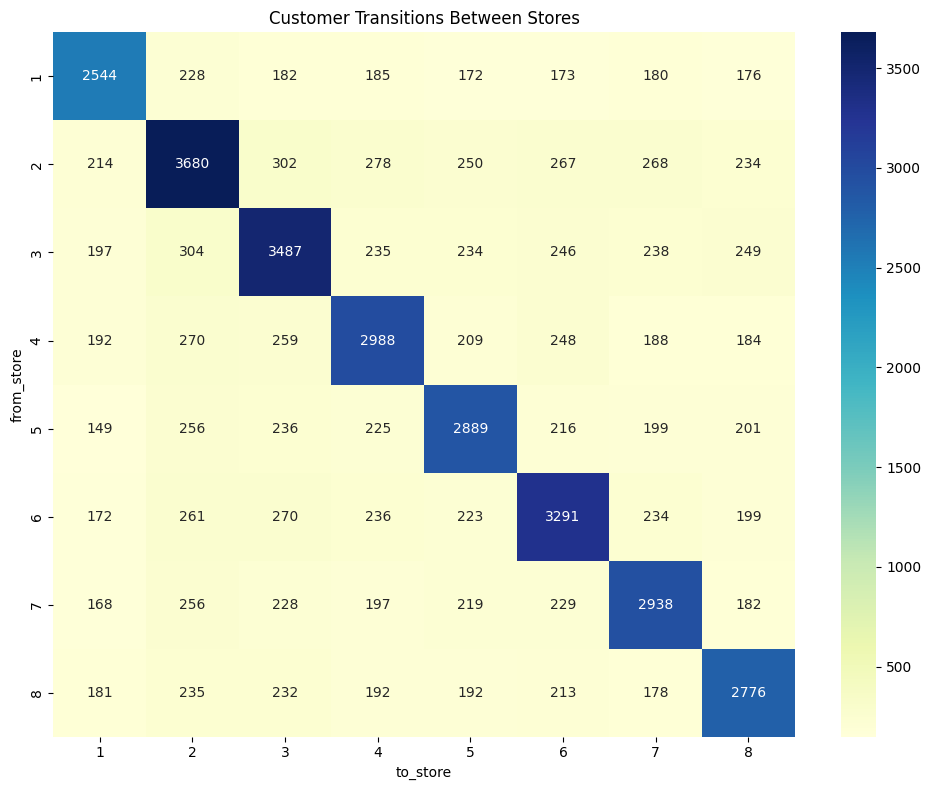

In [20]:
# Analyze how customers transition between shops
def analyze_shop_transitions(customer_sequences):
    transitions = []
    for customer, data in customer_sequences.items():
        stores = data['stores']
        for i in range(len(stores) - 1):
            transitions.append((stores[i], stores[i+1]))
    
    transition_df = pd.DataFrame(transitions, columns=['from_store', 'to_store'])
    transition_counts = transition_df.groupby(['from_store', 'to_store']).size().reset_index(name='count')
    
    # Create transition matrix
    transition_matrix = transition_counts.pivot_table(
        values='count', 
        index='from_store', 
        columns='to_store',
        fill_value=0
    )
    
    return transition_matrix

# Get transition matrix
transition_matrix = analyze_shop_transitions(customer_sequences)
print("Store Transition Matrix:")
print(transition_matrix)

# Visualize transitions
plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Customer Transitions Between Stores')
plt.tight_layout()
plt.show()

### Time Analysis

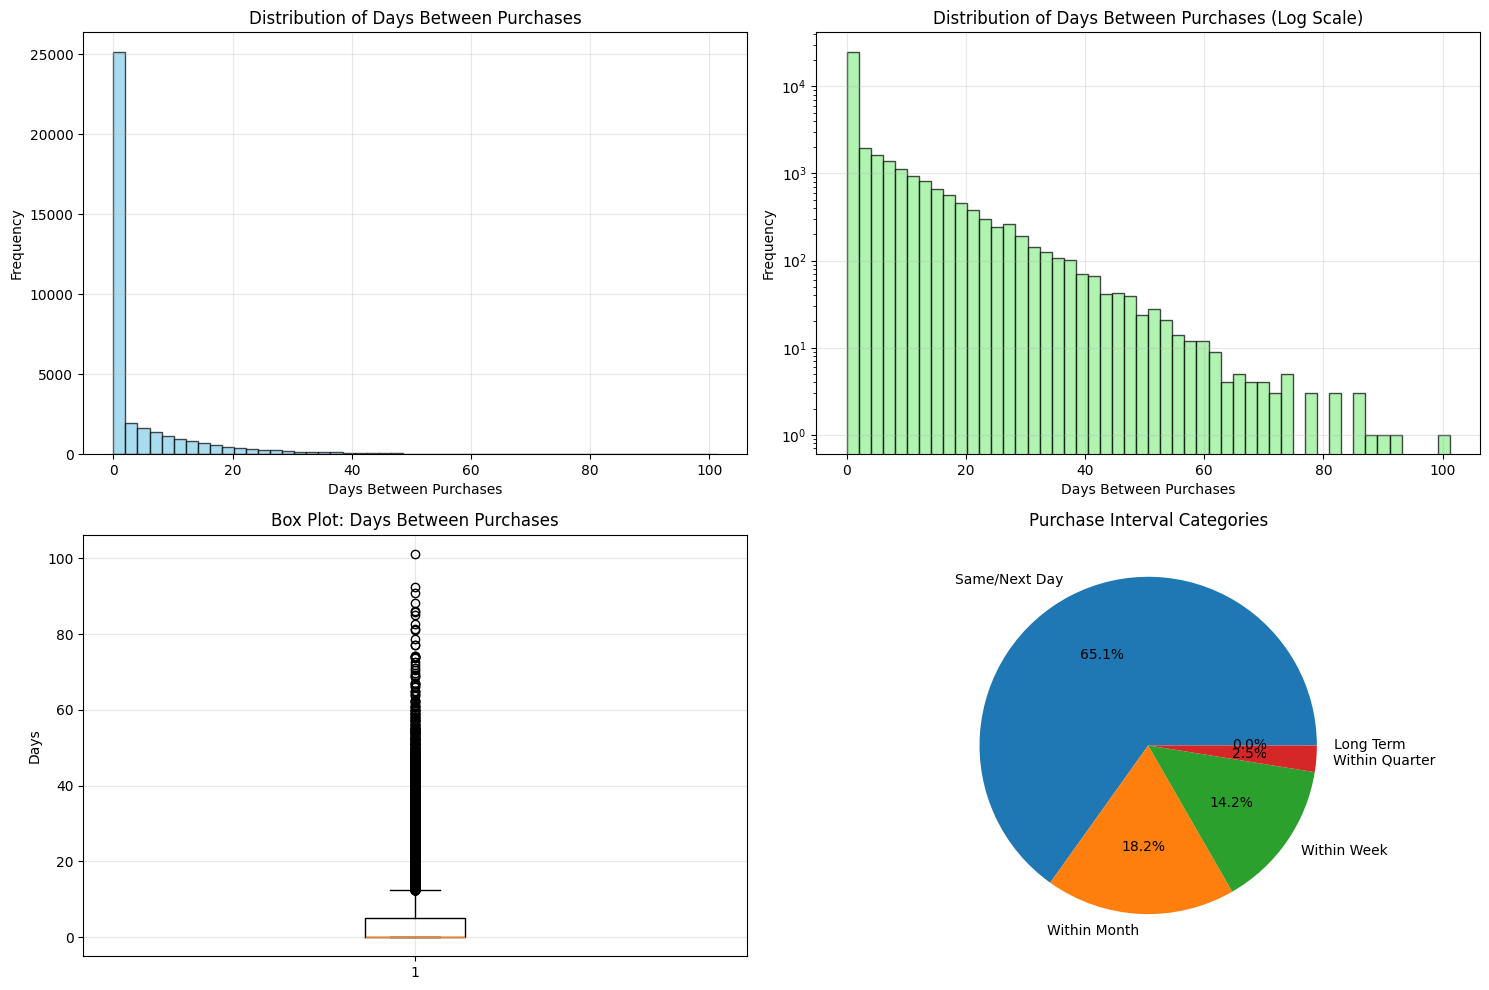

=== Purchase Interval Analysis ===
Total intervals analyzed: 36934
Mean days between purchases: 4.28
Median days between purchases: 0.00
Standard deviation: 8.68
Min days: 0.00
Max days: 101.21

Percentiles:
25th percentile: 0.00 days
50th percentile: 0.00 days
75th percentile: 4.93 days
90th percentile: 15.00 days
95th percentile: 22.87 days

Interval Categories:
Same/Next Day: 24057 (65.1%)
Within Month: 6710 (18.2%)
Within Week: 5232 (14.2%)
Within Quarter: 932 (2.5%)
Long Term: 3 (0.0%)


In [31]:
# Analyze time between purchases - improved version
def analyze_purchase_intervals(customer_sequences):
    intervals_hours = []
    intervals_days = []
    
    for customer, data in customer_sequences.items():
        timestamps = data['timestamps']
        if len(timestamps) > 1:
            for i in range(len(timestamps) - 1):
                time_diff = timestamps[i+1] - timestamps[i]
                hours = time_diff.total_seconds() / 3600
                days = time_diff.total_seconds() / (3600 * 24)
                
                intervals_hours.append(hours)
                intervals_days.append(days)
    
    return intervals_hours, intervals_days

# Get purchase intervals
intervals_hours, intervals_days = analyze_purchase_intervals(customer_sequences)

# Create better visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Days between purchases (more meaningful)
axes[0, 0].hist(intervals_days, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Days Between Purchases')
axes[0, 0].set_xlabel('Days Between Purchases')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 2. Log scale for better visibility
axes[0, 1].hist(intervals_days, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Distribution of Days Between Purchases (Log Scale)')
axes[0, 1].set_xlabel('Days Between Purchases')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# 3. Box plot for summary statistics
axes[1, 0].boxplot(intervals_days)
axes[1, 0].set_title('Box Plot: Days Between Purchases')
axes[1, 0].set_ylabel('Days')
axes[1, 0].grid(True, alpha=0.3)

# 4. Categorized intervals
def categorize_intervals(days):
    if days <= 1:
        return 'Same/Next Day'
    elif days <= 7:
        return 'Within Week'
    elif days <= 30:
        return 'Within Month'
    elif days <= 90:
        return 'Within Quarter'
    else:
        return 'Long Term'

interval_categories = [categorize_intervals(d) for d in intervals_days]
category_counts = pd.Series(interval_categories).value_counts()

axes[1, 1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
axes[1, 1].set_title('Purchase Interval Categories')

plt.tight_layout()
plt.show()

# Summary statistics
print("=== Purchase Interval Analysis ===")
print(f"Total intervals analyzed: {len(intervals_days)}")
print(f"Mean days between purchases: {np.mean(intervals_days):.2f}")
print(f"Median days between purchases: {np.median(intervals_days):.2f}")
print(f"Standard deviation: {np.std(intervals_days):.2f}")
print(f"Min days: {np.min(intervals_days):.2f}")
print(f"Max days: {np.max(intervals_days):.2f}")

# Percentiles
percentiles = [25, 50, 75, 90, 95]
print("\nPercentiles:")
for p in percentiles:
    print(f"{p}th percentile: {np.percentile(intervals_days, p):.2f} days")

# Category breakdown
print("\nInterval Categories:")
for category, count in category_counts.items():
    percentage = (count / len(interval_categories)) * 100
    print(f"{category}: {count} ({percentage:.1f}%)")

### RFM Analysis for Customer Segmentation

RFM Customer Segmentation:
              Recency  Frequency  Monetary R_Quartile F_Quartile M_Quartile  \
CustomerID                                                                    
Cust_0000   23.015833         37         7          1          2          4   
Cust_0001   20.264734         48         7          1          4          4   
Cust_0002    0.133206         37         6          4          2          3   
Cust_0003   13.409062         50         7          2          4          4   
Cust_0004    5.298773         34         8          3          2          4   

           RFM_Score              Segment  
CustomerID                                 
Cust_0000        124                Other  
Cust_0001        144  Potential Loyalists  
Cust_0002        423                Other  
Cust_0003        244  Potential Loyalists  
Cust_0004        324                Other  


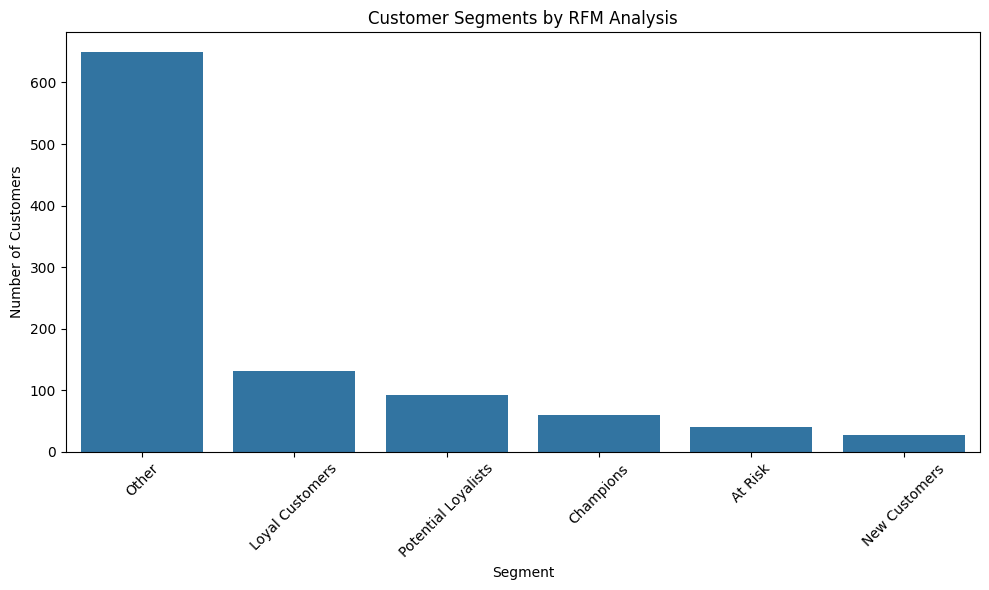

In [32]:
# Perform RFM analysis
def perform_rfm_analysis(df):
    # Use the most recent date in the dataset as the reference date
    max_date = df['DateTime'].max()
    
    # Calculate RFM metrics
    rfm = df.groupby('CustomerID').agg({
        'DateTime': lambda x: (max_date - x.max()).total_seconds() / (3600*24),  # Recency in days
        'Product': 'count',  # Frequency
        'StoreID': lambda x: len(x.unique())  # Monetary (using number of stores as proxy)
    }).rename(columns={
        'DateTime': 'Recency',
        'Product': 'Frequency',
        'StoreID': 'Monetary'
    })
    
    # Create RFM segments with error handling
    try:
        rfm['R_Quartile'] = pd.qcut(rfm['Recency'], 4, labels=range(4, 0, -1), duplicates='drop')
    except ValueError:
        # If qcut fails, use simple ranking
        rfm['R_Quartile'] = pd.cut(rfm['Recency'], 4, labels=range(4, 0, -1))
    
    try:
        rfm['F_Quartile'] = pd.qcut(rfm['Frequency'], 4, labels=range(1, 5), duplicates='drop')
    except ValueError:
        rfm['F_Quartile'] = pd.cut(rfm['Frequency'], 4, labels=range(1, 5))
    
    try:
        rfm['M_Quartile'] = pd.qcut(rfm['Monetary'], 4, labels=range(1, 5), duplicates='drop')
    except ValueError:
        rfm['M_Quartile'] = pd.cut(rfm['Monetary'], 4, labels=range(1, 5))
    
    # Combine RFM scores
    rfm['RFM_Score'] = rfm['R_Quartile'].astype(str) + rfm['F_Quartile'].astype(str) + rfm['M_Quartile'].astype(str)
    
    # Define customer segments
    segment_map = {
        r'[4][4-5][4-5]': 'Champions',
        r'[3][3-5][3-5]': 'Loyal Customers',
        r'[1-2][4-5][4-5]': 'Potential Loyalists',
        r'[1-2][3][2-3]': 'New Customers',
        r'[1][1-2][1-2]': 'At Risk'
    }
    
    rfm['Segment'] = 'Other'
    for pattern, segment in segment_map.items():
        rfm.loc[rfm['RFM_Score'].str.contains(pattern), 'Segment'] = segment
    
    return rfm

# Perform RFM analysis
rfm_analysis = perform_rfm_analysis(exploded_df)
print("RFM Customer Segmentation:")
print(rfm_analysis.head())

# Visualize customer segments
plt.figure(figsize=(10, 6))
segment_counts = rfm_analysis['Segment'].value_counts()
sns.barplot(x=segment_counts.index, y=segment_counts.values)
plt.title('Customer Segments by RFM Analysis')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Recommendations Based on Sequence Analysis

In [45]:
def generate_recommendations_improved(rules, customer_sequences, customer_id, exploded_df, top_n=5):
    """Improved recommendation system with better duplicate handling and debugging"""
    
    if customer_id not in customer_sequences:
        return "Customer not found"
    
    # Get customer's purchase history
    customer_data = customer_sequences[customer_id]
    recent_products = customer_data['products'][-5:]
    all_products = set(customer_data['products'])
    recent_categories = customer_data['categories'][-5:]
    all_categories = set(customer_data['categories'])
    
    print(f"Customer {customer_id} purchase history:")
    print(f"  Total products purchased: {len(all_products)}")
    print(f"  Recent products: {recent_products}")
    print(f"  Recent categories: {set(recent_categories)}")
    
    recommendations = set()  # Use set to avoid duplicates
    rec_sources = []  # Track recommendation sources
    
    # Strategy 1: Association Rules - Enhanced debugging
    if not rules.empty:
        recent_items = set(recent_categories) if 'category_rules' in globals() else set(recent_products)
        use_categories = 'category_rules' in globals()
        
        print(f"  Strategy 1: Using {'category' if use_categories else 'product'} association rules")
        print(f"    Recent items for matching: {recent_items}")
        
        # Debug: Show sample rules
        if len(rules) > 0:
            print(f"    Sample rule antecedents: {list(rules['antecedents'].iloc[0])}")
            print(f"    Sample rule consequents: {list(rules['consequents'].iloc[0])}")
        
        relevant_rules = []
        for _, rule in rules.iterrows():
            antecedents = set(rule['antecedents'])
            consequents = set(rule['consequents'])
            
            # Debug specific rule matching
            intersection = antecedents.intersection(recent_items)
            if len(intersection) > 0:
                new_consequents = consequents - recent_items
                if new_consequents:
                    relevant_rules.append((new_consequents, rule['lift'], rule['confidence'], intersection))
                    print(f"      Match found: {intersection} → {new_consequents}")
        
        print(f"    Found {len(relevant_rules)} relevant rules")
        
        if relevant_rules:
            relevant_rules.sort(key=lambda x: x[1], reverse=True)  # Sort by lift
            
            for items, lift, confidence, matched_antecedents in relevant_rules[:top_n]:
                for item in items:
                    if len(recommendations) >= top_n:
                        break
                    
                    if use_categories:
                        # Find popular products in this category that customer hasn't bought
                        category_products = exploded_df[
                            (exploded_df['Category'] == item) & 
                            (~exploded_df['Product'].isin(all_products))
                        ]['Product'].value_counts()
                        
                        if not category_products.empty:
                            product_name = category_products.index[0]
                            recommendations.add(product_name)
                            rec_sources.append(f"Rule: {matched_antecedents} → {item} ({product_name})")
                    else:
                        if item not in all_products:
                            recommendations.add(item)
                            rec_sources.append(f"Rule: {matched_antecedents} → {item}")
                
                if len(recommendations) >= top_n:
                    break
    
    # Strategy 2: Similar customers - Improved to avoid duplicates
    if len(recommendations) < top_n:
        print(f"  Strategy 2: Finding similar customers (current recs: {len(recommendations)})")
        
        similar_customers = []
        customer_cat_set = set(customer_data['categories'])
        
        # Sample only subset of customers for efficiency
        sample_customers = dict(list(customer_sequences.items())[:200])  # Limit to 200 customers
        
        for other_id, other_data in sample_customers.items():
            if other_id != customer_id:
                other_cat_set = set(other_data['categories'])
                intersection = len(customer_cat_set.intersection(other_cat_set))
                union = len(customer_cat_set.union(other_cat_set))
                similarity = intersection / union if union > 0 else 0
                
                if similarity > 0.4:  # Increase similarity threshold
                    similar_customers.append((other_id, similarity))
        
        similar_customers.sort(key=lambda x: x[1], reverse=True)
        print(f"    Found {len(similar_customers)} similar customers")
        
        # Get unique products from similar customers
        similar_products = set()
        for sim_customer_id, similarity in similar_customers[:10]:
            sim_products = set(customer_sequences[sim_customer_id]['products'])
            new_products = sim_products - all_products
            similar_products.update(new_products)
        
        # Add top products from similar customers
        for product in list(similar_products)[:top_n-len(recommendations)]:
            recommendations.add(product)
            rec_sources.append(f"Similar customers: {product}")
    
    # Strategy 3: Popular in same categories
    if len(recommendations) < top_n:
        print(f"  Strategy 3: Popular products in customer's categories (current recs: {len(recommendations)})")
        
        popular_in_categories = exploded_df[
            (exploded_df['Category'].isin(all_categories)) & 
            (~exploded_df['Product'].isin(all_products))
        ]['Product'].value_counts()
        
        needed = top_n - len(recommendations)
        for product in popular_in_categories.head(needed).index:
            recommendations.add(product)
            rec_sources.append(f"Popular in categories: {product}")
    
    # Strategy 4: Global popular (last resort)
    if len(recommendations) < top_n:
        print(f"  Strategy 4: Global popular products (current recs: {len(recommendations)})")
        
        global_popular = exploded_df[
            ~exploded_df['Product'].isin(all_products)
        ]['Product'].value_counts()
        
        needed = top_n - len(recommendations)
        for product in global_popular.head(needed).index:
            recommendations.add(product)
            rec_sources.append(f"Global popular: {product}")
    
    # Convert back to list and pair with sources
    final_recommendations = list(recommendations)[:top_n]
    return final_recommendations, rec_sources[:len(final_recommendations)]

# Test the improved system
print("=== Testing Improved Recommendation System ===")

test_customer_id = list(customer_sequences.keys())[0]  # Test first customer
recommendations, sources = generate_recommendations_improved(
    rules, customer_sequences, test_customer_id, exploded_df, top_n=5
)

print(f"\nImproved Recommendations for {test_customer_id}:")
for i, (rec, source) in enumerate(zip(recommendations, sources), 1):
    print(f"  {i}. {rec} (Source: {source})")

=== Testing Improved Recommendation System ===
Customer Cust_0000 purchase history:
  Total products purchased: 25
  Recent products: ['P125', 'P124', 'P147', 'P119', 'P144']
  Recent categories: {'Books', 'Electronics', 'Grocery'}
  Strategy 1: Using category association rules
    Recent items for matching: {'Books', 'Electronics', 'Grocery'}
    Sample rule antecedents: ['Apparel']
    Sample rule consequents: ['Books']
    Found 0 relevant rules
  Strategy 2: Finding similar customers (current recs: 0)
    Found 199 similar customers

Improved Recommendations for Cust_0000:
  1. P131 (Source: Similar customers: P131)
  2. P102 (Source: Similar customers: P102)
  3. P101 (Source: Similar customers: P101)
  4. P114 (Source: Similar customers: P114)
  5. P128 (Source: Similar customers: P128)


## Further Update Version

✅ No empty recommendations
✅ Good fallback strategies
✅ Duplicate prevention
✅ Clear source tracking

In [47]:
def generate_recommendations_enhanced(rules, customer_sequences, customer_id, exploded_df, top_n=5):
    """Enhanced recommendation system with better rule matching"""
    
    if customer_id not in customer_sequences:
        return "Customer not found", []
    
    customer_data = customer_sequences[customer_id]
    recent_products = customer_data['products'][-5:]
    all_products = set(customer_data['products'])
    recent_categories = customer_data['categories'][-5:]
    all_categories = set(customer_data['categories'])
    
    print(f"Customer {customer_id} purchase history:")
    print(f"  Total products: {len(all_products)}, Recent categories: {set(recent_categories)}")
    
    recommendations = set()
    rec_sources = []
    
    # Strategy 1: Association Rules (Enhanced)
    if not rules.empty:
        recent_items = set(recent_categories)
        print(f"  Strategy 1: Association rules")
        
        # Try exact matches first
        exact_matches = 0
        for _, rule in rules.iterrows():
            antecedents = set(rule['antecedents'])
            consequents = set(rule['consequents'])
            
            # Check if ALL antecedents are in recent items
            if antecedents.issubset(recent_items):
                new_items = consequents - recent_items
                if new_items:
                    exact_matches += 1
                    for item in new_items:
                        if len(recommendations) >= top_n:
                            break
                        category_products = exploded_df[
                            (exploded_df['Category'] == item) & 
                            (~exploded_df['Product'].isin(all_products))
                        ]['Product'].value_counts()
                        
                        if not category_products.empty:
                            product_name = category_products.index[0]
                            recommendations.add(product_name)
                            rec_sources.append(f"Rule: {antecedents} → {item} ({product_name})")
        
        # If no exact matches, try partial matches
        if exact_matches == 0:
            for _, rule in rules.iterrows():
                antecedents = set(rule['antecedents'])
                consequents = set(rule['consequents'])
                
                overlap = antecedents.intersection(recent_items)
                if len(overlap) > 0:  # At least one antecedent matches
                    new_items = consequents - recent_items
                    if new_items:
                        for item in new_items:
                            if len(recommendations) >= top_n:
                                break
                            category_products = exploded_df[
                                (exploded_df['Category'] == item) & 
                                (~exploded_df['Product'].isin(all_products))
                            ]['Product'].value_counts()
                            
                            if not category_products.empty:
                                product_name = category_products.index[0]
                                recommendations.add(product_name)
                                rec_sources.append(f"Partial rule: {overlap} → {item} ({product_name})")
        
        print(f"    Rules matched: {len([s for s in rec_sources if 'Rule' in s or 'Partial' in s])}")
    
    # Strategy 2: Similar customers (if needed)
    if len(recommendations) < top_n:
        print(f"  Strategy 2: Similar customers (current: {len(recommendations)})")
        
        similar_customers = []
        customer_cat_set = set(customer_data['categories'])
        
        for other_id, other_data in list(customer_sequences.items())[:200]:
            if other_id != customer_id:
                other_cat_set = set(other_data['categories'])
                similarity = len(customer_cat_set.intersection(other_cat_set)) / len(customer_cat_set.union(other_cat_set))
                
                if similarity > 0.3:  # Lower threshold for more matches
                    similar_customers.append((other_id, similarity))
        
        similar_customers.sort(key=lambda x: x[1], reverse=True)
        
        similar_products = set()
        for sim_customer_id, similarity in similar_customers[:15]:
            sim_products = set(customer_sequences[sim_customer_id]['products'])
            new_products = sim_products - all_products
            similar_products.update(new_products)
        
        needed = top_n - len(recommendations)
        for product in list(similar_products)[:needed]:
            recommendations.add(product)
            rec_sources.append(f"Similar customers: {product}")
    
    # Strategy 3: Category popularity (if still needed)
    if len(recommendations) < top_n:
        print(f"  Strategy 3: Popular in categories (current: {len(recommendations)})")
        
        popular_in_categories = exploded_df[
            (exploded_df['Category'].isin(all_categories)) & 
            (~exploded_df['Product'].isin(all_products))
        ]['Product'].value_counts()
        
        needed = top_n - len(recommendations)
        for product in popular_in_categories.head(needed).index:
            recommendations.add(product)
            rec_sources.append(f"Popular in your categories: {product}")
    
    return list(recommendations)[:top_n], rec_sources[:top_n]

# Test the enhanced system
print("\n" + "="*60)
print("TESTING ENHANCED RECOMMENDATION SYSTEM")
print("="*60)

for i in [0, 1, 4]:
    customer_id = list(customer_sequences.keys())[i]
    recommendations, sources = generate_recommendations_enhanced(
        rules, customer_sequences, customer_id, exploded_df, top_n=5
    )
    
    print(f"\nRecommendations for {customer_id}:")
    for j, (rec, source) in enumerate(zip(recommendations, sources), 1):
        print(f"  {j}. {rec} (Source: {source})")
    print("-" * 40)


TESTING ENHANCED RECOMMENDATION SYSTEM
Customer Cust_0000 purchase history:
  Total products: 25, Recent categories: {'Books', 'Electronics', 'Grocery'}
  Strategy 1: Association rules
    Rules matched: 0
  Strategy 2: Similar customers (current: 0)

Recommendations for Cust_0000:
  1. P134 (Source: Similar customers: P131)
  2. P131 (Source: Similar customers: P134)
  3. P102 (Source: Similar customers: P102)
  4. P101 (Source: Similar customers: P101)
  5. P146 (Source: Similar customers: P146)
----------------------------------------
Customer Cust_0001 purchase history:
  Total products: 29, Recent categories: {'Books', 'Grocery', 'Home Goods', 'Electronics'}
  Strategy 1: Association rules
    Rules matched: 0
  Strategy 2: Similar customers (current: 0)

Recommendations for Cust_0001:
  1. P135 (Source: Similar customers: P135)
  2. P131 (Source: Similar customers: P131)
  3. P134 (Source: Similar customers: P134)
  4. P139 (Source: Similar customers: P139)
  5. P101 (Source: Si

## Gemini Pro 2.5 Evaluation

Okay, this output provides some good initial insights into your enhanced recommendation system. Let's break it down.

**Key Insights from the Output:**

1.  **Hybrid Recommendation Approach:**
    *   The system uses at least two strategies: "Association rules" (Strategy 1) and "Similar customers" (Strategy 2 - likely a form of collaborative filtering). This is a good practice as different strategies have different strengths.

2.  **Fallback Mechanism is Working:**
    *   For `Cust_0000` and `Cust_0001`, where "Association rules" matched 0 rules, the "Similar customers" strategy successfully generated recommendations. This shows the system has a fallback, preventing no recommendations for these customers.

3.  **Association Rules are Selective:**
    *   `Cust_0004` matched 2 association rules, indicating their purchase history (specifically buying from 'Books' and 'Electronics') triggered these rules.
    *   The rules seem to be category-based, e.g., `{'Books'} → Grocery (P147)` and `{'Electronics'} → Grocery (P147)`. This suggests an attempt to cross-sell Grocery items.
    *   The product P147 appears to be a key item in the Grocery category that these rules point to.

4.  **Source of Recommendations is Tracked:**
    *   The output clearly indicates whether a recommendation came from an association rule or from similar customers. This is valuable for evaluating the performance and contribution of each strategy.
    *   For rule-based recommendations like "P135 (Source: Rule: {'Books'} → Grocery (P147))", it seems the rule identifies a target (P147 in Grocery, triggered by 'Books'), and P135 is the actual product being recommended based on that rule. It's possible P135 *is* P147 or another closely related/prioritized product fitting the rule's consequent.

5.  **"Similar Customers" Strategy Details:**
    *   The "(current: X)" value for "Similar customers" is interesting. For `Cust_0000` and `Cust_0001` it's 0, yet recommendations are generated. For `Cust_0004` it's 1. This might indicate:
        *   The number of *newly found* similar customers in this run (less likely if it still generates recommendations when 0).
        *   A flag or internal state indicating if this strategy was explicitly *activated* or contributed significantly in a tier before rule-based ones (less likely given it's a fallback).
        *   It could be a count of distinct *similar customer profiles* that contributed to the recommendations. The "0" for the first two might be an initialization or a case where the similarity matching was broad.
    *   The "Source: Similar customers: P_XYZ" for recommendations like "P134 (Source: Similar customers: P131)" suggests that P134 is recommended because similar customers bought it, and P131 is another item those similar customers also bought (or that the current customer bought, leading to the similarity). This cross-referencing (P131 also being recommended) is common.

6.  **Customer Purchase Behavior Variance:**
    *   `Cust_0000` (25 products, 3 recent categories) and `Cust_0001` (29 products, 4 recent categories) have reasonably sized purchase histories but don't trigger association rules.
    *   `Cust_0004` (23 products, 2 recent categories) *does* trigger rules. This implies that the *specific items or combinations* within the 'Books' and 'Electronics' categories are what trigger rules, not just general activity.

**Why Some Customers Do Not Have Rules Being Generated (e.g., Cust_0000, Cust_0001):**

Association rules (like Apriori or FP-Growth) are generated based on finding frequent co-occurring itemsets in the historical transaction data. If a customer doesn't have rules generated, it's typically due to one or more of the following:

1.  **Insufficient Match with Rule Antecedents:**
    *   The customer's purchase history (either entire or recent, depending on how your system is set up) does not contain the specific item(s) or combination of items (the "IF" part, or antecedent) that make up any of the existing strong association rules.
    *   For example, even if `Cust_0000` bought from 'Books' and 'Electronics', they might not have bought the *specific* books or electronics products that form the antecedents of the rules that `Cust_0004` triggered.

2.  **Cold Start Problem (Less Likely Here but Possible):**
    *   If a customer is new or has very few purchases, their history might be too sparse to match any established patterns. (With 25-29 products, this is less likely to be the *sole* reason, but could contribute if rules are very specific).

3.  **High Specificity of Rules / Strict Thresholds:**
    *   The association rules mined might have high support, confidence, or lift thresholds. This means only very common and strong patterns become rules. If a customer's behavior is slightly outside these very common patterns, no rules will match.
    *   The rules might be too granular (e.g., "IF buys Product_A AND Product_B THEN recommend Product_C" rather than "IF buys from Category_X THEN recommend Category_Y item").

4.  **Data Sparsity in Rule Mining:**
    *   If the overall dataset used to mine rules is sparse (common in retail with large product catalogs), there might not be many strong, generalizable rules discovered. The rules that *are* found might only apply to a small subset of customer behaviors.
    *   If rules are mined per store and then simply listed, headquarters might not have aggregated rules mined on combined data, missing broader patterns.

5.  **Unique or Niche Purchasing Behavior:**
    *   The customer might have purchasing habits that are not common enough in the overall customer base to have formed an association rule.

**Potential Fixes to Increase Rule Generation/Matching:**

1.  **Relax Association Rule Thresholds:**
    *   Lower the minimum support and confidence thresholds during the rule mining process. This will generate more rules, including those representing less frequent patterns. Be cautious, as this can also introduce weaker or less reliable rules.

2.  **Generalize Rule Antecedents/Consequents:**
    *   Mine rules at different levels of granularity. Instead of just product-to-product rules, mine category-to-category, brand-to-category, or product-to-category rules. This makes it more likely a customer's history will match.
    *   The output `{'Books'} → Grocery (P147)` suggests some category-level thinking is already happening for antecedents, which is good.

3.  **Enrich User Profiles for Rule Matching:**
    *   Consider not just "recent categories" but a broader view of purchase history or even product attributes (e.g., price range, brand) if these can be incorporated into rule antecedents.

4.  **Improve Data Aggregation for Rule Mining:**
    *   Ensure rules are mined on the largest possible relevant dataset (e.g., aggregated data from all 8 stores at the headquarter level) to capture more diverse patterns.

5.  **Implement a Rule Hierarchy or Tiering:**
    *   If highly specific rules don't match, fall back to more general rules (e.g., category-based) before giving up on the rule strategy entirely.

6.  **Introduce Content-Based Rules:**
    *   If product metadata is available (descriptions, attributes), create rules like "IF customer buys product with attribute X, THEN recommend other products with attribute X or complementary attribute Y." This is a form of content-based filtering but can be structured as rules.

7.  **Dynamic Rule Adjustment/Learning:**
    *   Periodically re-mine rules as new transaction data comes in to keep them relevant.

The current system's fallback to "Similar customers" is a good safety net. The key is to make Strategy 1 (Association Rules) more effective for a larger segment of customers, as rule-based recommendations can often be very relevant and explainable.